In [11]:
import numpy as np
import pandas as pd
from decimal import Decimal
from sklearn.datasets import load_iris
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [60]:
# 计算信息熵
class DecisionTree():
    def __init__(self,data,Continuous_attribute=[]):
        self.conAttr = Continuous_attribute
        self.tree = None
        self.depth = 0
        self.categoricalAttr={}
        for col in data.columns:
            if col in self.conAttr:
                continue
            self.categoricalAttr[col] = list(set(data[col]))

    def info(self,D):
        n=len(D)
        Labels={}
        for item in D:
            label = item
            Labels[label] = Labels.get(label,0) + 1
        entropy=0
        for i in Labels:
            p = Labels[i]/n
            entropy -= p*np.log2(p)
        return entropy

    # 计算信息增益
    def Gain(self,column,data):
        length = len(data)
        target = data.columns[-1]
        infoD=self.info(data.iloc[:,-1])
        
        if column in self.conAttr:
            sort=np.sort(data[column].unique())
            min_infofD=infoD
            best_split=0
            for i in range(len(sort)-1):
                split=float((Decimal(str(sort[i]))+Decimal(str(sort[i+1])))/2)
                index1=data[data[column]<split].index
                index2=data[data[column]>split].index
                
                weight1=len(data[data[column]<split])/length
                weight2=1-weight1
                print(str(weight1) +" "+str(self.info(data.loc[index1,target]))+ " " +str(weight2)+" "+str(self.info(data.loc[index2,target]) ))
                print("*")
                print(np.unique(data.loc[index1,target], return_counts=True))
                print(np.unique(data.loc[index2,target], return_counts=True))
                print("*")
                infofD=weight1 * self.info(data.loc[index1,target]) + weight2 * self.info(data.loc[index2,target])
                if infofD < min_infofD:
                    min_infofD=infofD
                    best_split=split
                print(infofD, best_split)
            print("\n")
            return infoD-min_infofD,best_split
        else:
            values = data[column].value_counts().index
            counts = data[column].value_counts().values
            infofD=0
            for i in range(len(values)):
                index = data[(data[column] == values[i])].index.tolist()
                weight = counts[i]/length
                infofD += weight * self.info(data.loc[index,target])
            return infoD-infofD

    # 计算最大信息增益的属性
    def getMaxgain(self,data):
        max_gain = 0
        max_label=None
        best_split=0
        cols = data.columns[:-1]
        for col in cols:
            gain,split=0,0
            if col in self.conAttr:
                gain ,split = self.Gain(col,data)
            else:
                gain = self.Gain(col,data)
            if gain > max_gain:
                max_gain=gain
                max_label=col
                best_split=split
                
        return max_label,best_split

    # 获取一个节点中，样本数最多的类别标签
    def getMostlabel(self,label_list):
        return label_list.value_counts().idxmax()

    # 创建决策树
    def fit(self,train):
        feature = train.columns[:-1]
        label_list = train.iloc[:,-1]
        # 如果样本全属于同一类，此节点为叶子节点
        if len(pd.unique(label_list)) == 1:
            return label_list.values[0]
        # 如果待划分的属性集A为空，或者样本在属性A上取值相同，则把该节点作为叶节点，并标记为样本数最多的分类
        elif len(feature)==0 or len(train.loc[:,feature].drop_duplicates())==1:
            return self.getMostlabel(label_list)
        # 获取最优划分属性
        best_attr,best_split = self.getMaxgain(train)
        tree = {best_attr:{}}
        # 按划分生成分支
        self.depth += 1
        if best_attr in self.conAttr:
            bigger = '>'+str(best_split)
            smaller = '<'+str(best_split)
            bigger_data=train[train[best_attr]>best_split].drop(best_attr,axis=1)
            smaller_data=train[train[best_attr]<best_split].drop(best_attr,axis=1)
            tree[best_attr][bigger]=self.fit(bigger_data)
            tree[best_attr][smaller]=self.fit(smaller_data)
        else:
            for attr in self.categoricalAttr[best_attr]:
                node = train[train[best_attr]==attr]
                if len(node) == 0:
                    tree[best_attr][attr] = self.getMostlabel(label_list)
                else:
                    new_data = node.drop(best_attr,axis=1)
                    tree[best_attr][attr] = self.fit(new_data)
        self.depth -= 1
        if self.depth != 0:
            return tree
        else:
            self.tree = tree

    #使用递归函数进行分类
    def predict_Onepoint(self,point,tree):
        feature = list(tree.keys())[0]
        label = point[feature]
        if feature in self.conAttr:
            if eval(str(label)+list(tree[feature].keys())[0]):
                next_tree = tree[feature][list(tree[feature].keys())[0]]
            else:
                next_tree = tree[feature][list(tree[feature].keys())[1]]
        else:
            next_tree = tree[feature][label]
            
        if type(next_tree) != dict:
            return next_tree
        else:
            return self.predict_Onepoint(point,next_tree)
        
    def predict(self,data):
        n = len(data)
        pre=[]
        for i in range(n):
            pre.append(self.predict_Onepoint(data.iloc[i,:],self.tree))
        return pre
    
    def score(self,y_test,y_predict):
        return accuracy_score(y_test,y_predict)

In [65]:
data1 = pd.read_csv(r"D:/资料/大三下/数据挖掘/project2/abalone/abalone.data",header = None)
X_train, X_test, y_train, y_test = train_test_split(data1.iloc[:,:-1], data1.iloc[:,-1], test_size = 0.2, random_state=0)
train = pd.concat([X_train,y_train],axis=1)


In [66]:
decition_tree = DecisionTree(train,columns)
decition_tree.fit(train)
#预测并计算准确率
y_predict = decition_tree.predict(X_test) 
decition_tree.score(y_test,y_predict)

KeyError: 1.16

In [32]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data.iloc[:,-1], test_size = 0.2, random_state=1)
train = pd.concat([X_train,y_train],axis=1)
#训练模型
decition_tree = DecisionTree([1])
decition_tree.fit(train)
#预测并计算准确率
y_predict = decition_tree.predict(X_test)
decition_tree.score(y_test,y_predict)

AttributeError: 'list' object has no attribute 'columns'

In [13]:
Iris = load_iris()
X = Iris.data
y = Iris.target
columns=Iris.feature_names

In [63]:
np.unique(train["sepal length (cm)"],return_counts=True)

(array([4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2, 5.3, 5.4, 5.5,
        5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8,
        6.9, 7. , 7.1, 7.2, 7.4, 7.6, 7.7, 7.9]),
 array([1, 2, 1, 3, 2, 3, 5, 6, 8, 4, 1, 5, 5, 4, 8, 6, 3, 4, 2, 2, 8, 6,
        4, 2, 7, 2, 4, 1, 1, 3, 1, 1, 4, 1], dtype=int64))

In [64]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data.iloc[:,-1], test_size = 0.2, random_state=1)
train = pd.concat([X_train,y_train],axis=1)
#训练模型
decition_tree = DecisionTree(train,columns)
decition_tree.fit(train)
#预测并计算准确率
y_predict = decition_tree.predict(X_test) 
decition_tree.score(y_test,y_predict)

0.008333333333333333 0.0 0.9916666666666667 1.5806496014661915
*
(array([0.]), array([1], dtype=int64))
(array([0., 1., 2.]), array([38, 37, 44], dtype=int64))
*
1.5674775214539733 4.35
0.025 0.0 0.975 1.5790650118890843
*
(array([0.]), array([3], dtype=int64))
(array([0., 1., 2.]), array([36, 37, 44], dtype=int64))
*
1.5395883865918571 4.45
0.03333333333333333 0.0 0.9666666666666667 1.5778976214949338
*
(array([0.]), array([4], dtype=int64))
(array([0., 1., 2.]), array([35, 37, 44], dtype=int64))
*
1.5253010341117694 4.55
0.06666666666666667 0.0 0.9333333333333333 1.5703473205370204
*
(array([0.]), array([8], dtype=int64))
(array([0., 1., 2.]), array([31, 37, 44], dtype=int64))
*
1.4656574991678857 4.65
0.075 0.0 0.925 1.567645743678324
*
(array([0.]), array([9], dtype=int64))
(array([0., 1., 2.]), array([30, 37, 44], dtype=int64))
*
1.4500723129024498 4.75
0.11666666666666667 0.0 0.8833333333333333 1.5480980914247053
*
(array([0.]), array([14], dtype=int64))
(array([0., 1., 2.]), arr

(array([0., 1., 2.]), array([33, 37, 44], dtype=int64))
*
1.4959974160636613 1.35
0.15 0.0 0.85 1.5233720907296704
*
(array([0.]), array([18], dtype=int64))
(array([0., 1., 2.]), array([21, 37, 44], dtype=int64))
*
1.2948662771202197 1.45
0.24166666666666667 0.0 0.7583333333333333 1.3848930281417091
*
(array([0.]), array([29], dtype=int64))
(array([0., 1., 2.]), array([10, 37, 44], dtype=int64))
*
1.050210546340796 1.55
0.2916666666666667 0.0 0.7083333333333333 1.221570162628146
*
(array([0.]), array([35], dtype=int64))
(array([0., 1., 2.]), array([ 4, 37, 44], dtype=int64))
*
0.8652788651949367 1.65
0.31666666666666665 0.0 0.6833333333333333 1.0774938857362273
*
(array([0.]), array([38], dtype=int64))
(array([0., 1., 2.]), array([ 1, 37, 44], dtype=int64))
*
0.736287488586422 1.8
0.325 0.0 0.675 0.9946059813005232
*
(array([0.]), array([39], dtype=int64))
(array([1., 2.]), array([37, 44], dtype=int64))
*
0.6713590373778532 2.6
0.3416666666666667 0.2811937964320427 0.6583333333333333 0

0.06172839506172839 0.7219280948873623 0.9382716049382716 0.9874750082985964
*
(array([1., 2.]), array([4, 1], dtype=int64))
(array([1., 2.]), array([33, 43], dtype=int64))
*
0.971083223520125 5.35
0.1111111111111111 0.5032583347756457 0.8888888888888888 0.972552316568843
*
(array([1., 2.]), array([8, 1], dtype=int64))
(array([1., 2.]), array([29, 43], dtype=int64))
*
0.9204085408140432 5.55
0.16049382716049382 0.6193821946787638 0.8395061728395061 0.9596868937742169
*
(array([1., 2.]), array([11,  2], dtype=int64))
(array([1., 2.]), array([26, 42], dtype=int64))
*
0.9050700902156874 5.65
0.2222222222222222 0.6500224216483541 0.7777777777777778 0.9333572600179805
*
(array([1., 2.]), array([15,  3], dtype=int64))
(array([1., 2.]), array([22, 41], dtype=int64))
*
0.870393962602508 5.75
0.2839506172839506 0.828055725379504 0.7160493827160495 0.9293636260137187
*
(array([1., 2.]), array([17,  6], dtype=int64))
(array([1., 2.]), array([20, 38], dtype=int64))
*
0.9005971850928924 5.75
0.3209

(array([2.]), array([32], dtype=int64))
*
0.1104713417800198 5.95
0.24390243902439024 0.4689955935892812 0.7560975609756098 0.0
*
(array([1., 2.]), array([1, 9], dtype=int64))
(array([2.]), array([31], dtype=int64))
*
0.11438916916811737 5.95
0.2926829268292683 0.41381685030363374 0.7073170731707317 0.0
*
(array([1., 2.]), array([ 1, 11], dtype=int64))
(array([2.]), array([29], dtype=int64))
*
0.1211171269181367 5.95
0.3902439024390244 0.3372900666170139 0.6097560975609756 0.0
*
(array([1., 2.]), array([ 1, 15], dtype=int64))
(array([2.]), array([25], dtype=int64))
*
0.131625391850542 5.95
0.5121951219512195 0.2761954276479391 0.4878048780487805 0.0
*
(array([1., 2.]), array([ 1, 20], dtype=int64))
(array([2.]), array([20], dtype=int64))
*
0.1414659507465054 5.95
0.6097560975609756 0.24229218908241482 0.3902439024390244 0.0
*
(array([1., 2.]), array([ 1, 24], dtype=int64))
(array([2.]), array([16], dtype=int64))
*
0.14773913968439928 5.95
0.7317073170731707 0.21084230031853213 0.268292

0.4610546925665634 2.25
0.75 0.4689955935892812 0.25 0.4689955935892812
*
(array([1., 2.]), array([27,  3], dtype=int64))
(array([1., 2.]), array([9, 1], dtype=int64))
*
0.4689955935892812 2.25
0.875 0.512709142030877 0.125 0.0
*
(array([1., 2.]), array([31,  4], dtype=int64))
(array([1.]), array([5], dtype=int64))
*
0.4486204992770174 3.05
0.95 0.4854607607459134 0.050000000000000044 0.0
*
(array([1., 2.]), array([34,  4], dtype=int64))
(array([1.]), array([2], dtype=int64))
*
0.4611877227086177 3.05
0.975 0.4770713062193297 0.025000000000000022 0.0
*
(array([1., 2.]), array([35,  4], dtype=int64))
(array([1.]), array([1], dtype=int64))
*
0.46514452356384645 3.05


0.13636363636363635 0.9182958340544896 0.8636363636363636 0.6292492238560345
*
(array([1., 2.]), array([2, 1], dtype=int64))
(array([1., 2.]), array([16,  3], dtype=int64))
*
0.6686646707012784 2.25
0.18181818181818182 0.8112781244591328 0.8181818181818181 0.6500224216483541
*
(array([1., 2.]), array([3, 1], dtype=int64))
(

0.9666666666666667

In [27]:
decition_tree.tree

{'petal length (cm)': {'>2.35': {'petal width (cm)': {'>1.75': {'sepal length (cm)': {'>5.95': 2.0,
      '<5.95': {'sepal width (cm)': {'>3.1': 1.0, '<3.1': 2.0}}}},
    '<1.75': {'sepal length (cm)': {'>7.1': 2.0,
      '<7.1': {'sepal width (cm)': {'>2.85': 1.0, '<2.85': 1.0}}}}}},
  '<2.35': 0.0}}

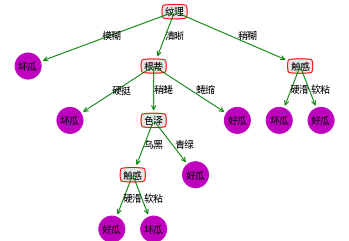

In [79]:
#为了matplotlib中文正常显示，指定字体为SimHei
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['font.family']='sans-serif'

#定义判断结点形状,其中boxstyle表示文本框类型,fc指的是注释框颜色的深度
decisionNode = dict(boxstyle="round4", color='r', fc='0.9')
#定义叶结点形状
leafNode = dict(boxstyle="circle", color='m')
#定义父节点指向子节点或叶子的箭头形状
arrow_args = dict(arrowstyle="<-", color='g')
 
def plot_node(node_txt, center_point, parent_point, node_style):
    '''
    绘制父子节点，节点间的箭头，并填充箭头中间上的文本
    :param node_txt:文本内容
    :param center_point:文本中心点
    :param parent_point:指向文本中心的点
    '''
    createPlot.ax1.annotate(node_txt, 
                            xy=parent_point,
                            xycoords='axes fraction',
                            xytext=center_point,
                            textcoords='axes fraction',
                            va="center",
                            ha="center",
                            bbox=node_style,
                            arrowprops=arrow_args)

def get_leafs_num(tree_dict):
    '''
    获取叶节点的个数
    :param tree_dict:树的数据字典
    :return tree_dict的叶节点总个数
    '''
    #tree_dict的叶节点总数
    leafs_num = 0
    
    #字典的第一个键，也就是树的第一个节点
    root = list(tree_dict.keys())[0]
    #这个键所对应的值，即该节点的所有子树。
    child_tree_dict =tree_dict[root]
    for key in child_tree_dict.keys():
        #检测子树是否字典型
        if type(child_tree_dict[key]).__name__=='dict':
            #子树是字典型，则当前树的叶节点数加上此子树的叶节点数
            leafs_num += get_leafs_num(child_tree_dict[key])
        else:
            #子树不是字典型，则当前树的叶节点数加1
            leafs_num += 1
 
    #返回tree_dict的叶节点总数
    return leafs_num
 
def get_tree_max_depth(tree_dict):
    '''
    求树的最深层数
    :param tree_dict:树的字典存储
    :return tree_dict的最深层数
    '''
    #tree_dict的最深层数
    max_depth = 0
    
    #树的根节点
    root = list(tree_dict.keys())[0]
    #当前树的所有子树的字典
    child_tree_dict = tree_dict[root]
    
    for key in child_tree_dict.keys():
        #树的当前分支的层数
        this_path_depth = 0
        #检测子树是否字典型
        if type(child_tree_dict[key]).__name__ == 'dict':
            #如果子树是字典型，则当前分支的层数需要加上子树的最深层数
            this_path_depth = 1 + get_tree_max_depth(child_tree_dict[key])
        else:
            #如果子树不是字典型，则是叶节点，则当前分支的层数为1
            this_path_depth = 1
        if this_path_depth > max_depth:
            max_depth = this_path_depth
    
    #返回tree_dict的最深层数
    return max_depth
 
def plot_mid_text(center_point, parent_point, txt_str):
    '''
    计算父节点和子节点的中间位置，并在父子节点间填充文本信息
    :param center_point:文本中心点
    :param parent_point:指向文本中心点的点
    '''
    
    x_mid = (parent_point[0] - center_point[0])/2.0 + center_point[0]
    y_mid = (parent_point[1] - center_point[1])/2.0 + center_point[1]
    createPlot.ax1.text(x_mid, y_mid, txt_str)
    return
 
def plotTree(tree_dict, parent_point, node_txt):
    '''
    绘制树
    :param tree_dict:树
    :param parent_point:父节点位置
    :param node_txt:节点内容
    '''
    
    leafs_num = get_leafs_num(tree_dict)
    root = list(tree_dict.keys())[0]
    #plotTree.totalW表示树的深度
    center_point = (plotTree.xOff+(1.0+float(leafs_num))/2.0/plotTree.totalW,plotTree.yOff)
    #填充node_txt内容
    plot_mid_text(center_point, parent_point, node_txt)
    #绘制箭头上的内容
    plot_node(root, center_point, parent_point, decisionNode)
    #子树
    child_tree_dict = tree_dict[root]
    plotTree.yOff=plotTree.yOff-1.0/plotTree.totalD
    #因从上往下画，所以需要依次递减y的坐标值，plotTree.totalD表示存储树的深度
    for key in child_tree_dict.keys():
        if type(child_tree_dict[key]).__name__ == 'dict':
            plotTree(child_tree_dict[key],center_point,str(key))
        else:
            plotTree.xOff=plotTree.xOff+1.0/plotTree.totalW
            plot_node(child_tree_dict[key],(plotTree.xOff,plotTree.yOff),center_point,leafNode)
            plot_mid_text((plotTree.xOff,plotTree.yOff),center_point,str(key))
    #h绘制完所有子节点后，增加全局变量Y的偏移
    plotTree.yOff=plotTree.yOff+1.0/plotTree.totalD
 
    return
 
def createPlot(tree_dict):
    '''
    绘制决策树图形
    :param tree_dict
    :return 无
    '''
    #设置绘图区域的背景色
    fig=plt.figure(1,facecolor='white')
    #清空绘图区域
    fig.clf()
    #定义横纵坐标轴,注意不要设置xticks和yticks的值!!!
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1=plt.subplot(111, frameon=False, **axprops)
    #由全局变量createPlot.ax1定义一个绘图区，111表示一行一列的第一个，frameon表示边框,**axprops不显示刻度
    plotTree.totalW=float(get_leafs_num(tree_dict))
    plotTree.totalD=float(get_tree_max_depth(tree_dict))
    plotTree.xOff=-0.5/plotTree.totalW;
    plotTree.yOff=1.0;
    plotTree(tree_dict, (0.5,1.0), '')
    plt.savefig('./tree.svg')
    plt.show()

createPlot(tree.tree)

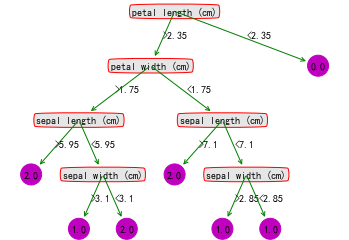

In [80]:
createPlot(decition_tree.tree)